This model was developed to support thr hypothesis that the set of differential equations developed for AKS
would work for all solutin polymerizations.
These results fuly support the hypothesis.
The generated files and plots match the original paper:
Molecular Weight Control of a Batch Polymerization Reactor: Experimental Study
Ind.Eng.Chem.Res. 1999, 38, 38, 144-153

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#%matplotlib  inline
import csv
from Plot_Library1 import *

In [2]:
def Arrhenius_joules( A, Ea, T):
    """
    return the rate constant
    input is temperature in Centigrade
    default R in Joules
    """
    R= 8.3144 # j/K/mol
    TK = T + 273.15
    return A*np.exp(-Ea/(R*TK))

In [3]:
def Arrhenius_cal( A, Ea, T):
    """
    return the rate constant
    input is temperature in Centigrade
    this R in calories, not kilocalories
    Used in all WATPOLY equations
    """
    R = 1.987204258 #cal/(K mol)
    TK = T + 273.15
    return A*np.exp(-Ea/(R*TK))


In [4]:
#makes it look nice
format_and_print = lambda nums: print(' '.join([f'{num:.2e}' for num in nums])) #[1=>many items are printed]

In [5]:
#basic chemical data for model
#amounts used
Wm = 3.492 #wgt kgrams monomer kgrams per original paper
Ws = 5.239 #wgt toluene kgrams
Wi = .082  #wgt AIBN kgrams
#molecular weights
Mwm = .10013 #mol wgt MMA kg/mol
Mws = .9215  #mol wgt solvent(toluene) kg/mol #OK
Mwi = .16421 
#system constants
R= 8.3144 # j/K/mol


In [6]:
#data from paper
x_obs_40 = [7045.,18374.,28916.,39822,50719,61588,72044,81285,92430	]
y_obs_40 = [0.04318, 0.12487,.17602	,0.26459,0.34805,0.41788,0.49801,0.55106,0.61404 ]
x_obs_50 = [3002.4,7344.0,10636.8,17676.0,27331.8,32385.6,38881.2 ]
y_obs_50 = [0.0712,0.16608,0.23723,0.39311,0.5537,0.63993,0.72082 ]
x_obs_60 = [1887.0,3918.6,7205.4,10739.4,14253.6]
y_obs_60 = [0.107,0.21397,0.39057,0.53817,0.67214 ]
x_obs_70 = [63.0,1102.2,2141.4,3270.6,4210.2,5967.0,6670.8 ]
y_obs_70 = [0.10238,0.18582,0.34092,0.46871,0.57435,0.65425,0.71556 ]

In [7]:
def Calculate_Residual(solution_array, x_obs, y_obs):
    """
        Use with output from solve_ivp only
    """
    #set up numpy arrays for calculations
    time_array = solution_array.t.astype(int)
    x_obs_integer = np.array(x_obs).astype(int)  
    residual_array = []
    difference_array = []
    for item in x_obs_integer:
        target_integer = item     
        y_loc = np.where(x_obs_integer == item)[0][0]     
        position = np.nonzero(time_array == target_integer)[0][0]
        calculated_conversion = 1 - (sol.y[1,position]/M0 )
        observed_position = y_loc
        difference_array.append( (calculated_conversion - y_obs[y_loc] )**2 ) 
    
    final_residual = sum(difference_array)    
    #print(final_residual)
    #print (f'residual = {final_residual:.3f} at T = {T} and f= {f} with kp= {int(kp)}') #int assign is optional
    return final_residual, difference_array

In [8]:

#Temperature_List = [40, 50, 60, 70]
Temperature_List = [40]
f = 0.58
data_to_file = False
write_residuals = False

In [9]:
def Get_Densities(T):
    rhom = 996.5 - 1.1 * (T) #monomer density kg/m^3 or kg/L
    rhom = rhom/1000
    print('rhom =', rhom, 'at T=', T)
    #print (rhom)  at 70 the value is 919.5 g/L
    rhos = 884 - 0.9 * (T)   #solvent density kg/m^3 or g/L #TRH modified
    rhos = rhos/1000
    #print('rhos =', rhos, 'at T=', T)
    #toluene is .862 at 25
    #toluene is 866.9 at 20
    rhoi = 1.000     #from 1.2         #initiator density kg/m^3 or g/L
    rhop = 1.195 - 3.3*(1.e-3)*(T) # [g/cm3] polymer density (T in oC, WATPOLY)
    #poly(MMA) is 1.18 at rt
    #print('rhop =', rhop, 'at T=', T)
    eta = (rhop-rhom)/rhop  #shrinkage factor at full conversion of all monomers to polymer
    return rhoi, rhom, rhop, rhos, eta


In [10]:
def Get_Volumes(T):

    #calculate volume V, constant during CL run
    Vm = Wm/rhom #OK
    #print (Wm, rhom, Vm)
    Vs = Ws/rhos 
    #print (Ws, rhos, Vs)
    Vi = Wi/rhoi 
    #print (Wi, rhoi, Vi)
    V = Vm + Vs + Vi
    return V, Vi, Vm, Vs

#V, Vi, Vm, Vs = Get_Volumes(T)
#volume_data= [V, Vi, Vm, Vs] 
#print(f'    V,      Vi,       Vm,    Vs      all at: {T}')
#format_and_print(volume_data)
# Predici shows 13.86 for CCL
# Predici shows 15.986 for CCL at 50 on 10/20


In [11]:
def Establish_kd(A, Ea, T):
### NOTE Chang_Liao uses Joules ##########################
    #first, use values from their table 8
    #print(f'Chang_Liao kd_joules seconds : {kd_joules:.3e}' )
    #print(f'Chiang_Liao kd_cal seconds : {kd_cal:.3e}' )
   
    kd_joules = Arrhenius_joules(A, Ea, T)  #original equation in seconds
    print (f'kd of AIBN from is generally OK {kd_joules:.3e}, extra Ea/R: {Ea/R:.3e} ')
    #PREDICI has 1.47e-6
    kd = kd_joules
    return kd
#A = 9.592e+15  #from Watpoly and paper
#Ea = 1.343e+5  #from Watpoly and paper  
#kd =  Establish_kd(A, Ea, T)   
#print(f'Integration system uses kd in seconds : {kd:.3e}' )
#kd of AIBN from is generally OK 3.806e-07, extra Ea/R: 1.615e+04 

In [12]:
#================= Create data file ++++++++++++++
fname = 'CL_rate_data.csv'
if data_to_file:
    row = [fname, 'rate of:', "T", 'Calculated Value', 'A', 'Ea', 'Ea/R']
    with open('CL_rate_data.csv', "a") as myf:
    	print(row, file = myf)

    row = (fname, 'kd      ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R)
    with open('CL_rate_data.csv', "a") as myf:
        print(row, file = myf)

In [13]:
def Get_kp( T):
#calculate kp
    A = 1.310e+14  #Table 8
    Ea = 7.065e+4
    #======== interesting below but not for model
    #kp_CL_opt  = Arrhenius_joules(1.75e+14, 7.065e+4, T) #A value dialed in to match
    #kp_CL_opt2 = Arrhenius_joules(1.38e+14, 7.008e+4, T) #Ea value dialed in to match
    #print(f'rates kp1 table 8 CL_opt : {kp_CL_opt:.3e} ' )
    #print(f'rates kp1 table 8 CL_opt2: {kp_CL_opt2:.3e} ' )
    #================================================
    kp_CL = Arrhenius_joules(A, Ea, T)
    print(f'rate kp1 table 8 CL   : {kp_CL:.3e} ' )
    print (f' for kp, Ea/R=          {Ea/R:.3e} ')
    
    if data_to_file:
        row = [fname, 'kp    ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R]
        with open('CL_rate_data.csv', "a") as myf:
            	print(row, file = myf)
    
    
    #IUPAC ===================
    A = 2.673e+6
    Ea = 22360
    #Ea = Ea * 1000  #kilojoules to joules
    # at 50C kp = 650  L * mol-1 s-1 by IUPAC
    kp_IUPAC = Arrhenius_joules(A, Ea, T)       
    print(f'rates kp IUPAC        : {kp_IUPAC:.3e}' )
    #End IUPAC =================
    
    #WATPOLY   =================
    kp_watpoly = Arrhenius_cal(2.952e+7, 4353, T) / 60   #convert minutes to seconds
    print(f'rates kp WATPOLY (sec): {kp_watpoly:.3e}' )
    #End WATPOLY
    kp = kp_IUPAC
    kp = kp_watpoly
    kp = kp_CL
    return kp

#kp = Get_kp(T)


#print(f'Integration system uses kp in seconds : {kp:.3e} at T = {T}' )
#print('This appears to be a bit low')
if data_to_file:
    row = [fname, 'kp    ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R]
    with open('CL_rate_data.csv', "a") as myf:
        	print(row, file = myf)



In [14]:
def Calculate_Other_Rates(T):
    #Other rate constants
    #using Table 8
    #kt
    A = 8.498e+21
    Ea = 8.851e+4
    kt =  Arrhenius_joules(A, Ea, T)  #Table 
    print(f'rates kt table 8 CL  : {kt:.3e} ' )
    if data_to_file:
        row = [fname, 'kt    ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R]
        with open('CL_rate_data.csv', "a") as myf:
            	print(row, file = myf)
    #ktrm transfer to momomer
    A = 2.886e+1
    Ea = 4.268e+4
    ktrm =  Arrhenius_joules(A, Ea, T)  #Table 
    print(f'rates ktrm table 8 CL : {ktrm:.3e} ' )
    ktrm  = 1.068000 
    print(f'rates ktrm Lemette : {ktrm:.3e} ' )
    if data_to_file:
        row = [fname, 'ktrm    ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R]
        with open('CL_rate_data.csv', "a") as myf:
            	print(row, file = myf)
    
    
    #kts transfer to solvent
    A = 4.487e+6
    Ea = 6.816e+4
    kts =  Arrhenius_joules(A, Ea, T)  #Table 8
    print(f'rates kts table 8 CL  : {kts:.3e} ' )
    if data_to_file:
        row = [fname, 'kts    ', T, Arrhenius_joules(A, Ea, T), A, Ea, Ea/R]
        with open('CL_rate_data.csv', "a") as myf:
            	print(row, file = myf)
    
    
    #ktcd combination term
    A = 6.639e-11
    Ea = 6.125e+4
    ktcd =  Arrhenius_joules(A, Ea, T)  #Table 
    print(f'rates ktcd table 8 CL  : {ktcd:.3e} ' )
    #kt = ktc + ktd
    #ktcd = ktc / ktd
    #termination by disproportination
    #ktd  = ktc-(ktcd)
    ktd_final=kt/(1+ktcd)
    ktd = ktd_final
    print(f'rates ktd calculated     {ktd:.3e} ')
    
    
    #termination by combination
    ktc = kt/(1+ ktcd)
    ktc_final =ktd*ktcd
    ktc = ktc_final
    print(f'rates ktc table 8 C     {ktc:.3e} ')
    
    
    return kt, ktc, ktd, ktrm, kts, ktcd

if data_to_file:
    row = [fname, 'ktc    ', T, ktc , 'calculated ']
    with open('CL_rate_data.csv', "a") as myf:
        print(row, file = myf)
# kt=ktc+ktd       

if data_to_file:
    row = [fname, 'ktd    ', T, ktc , 'calculated ']
    with open('CL_rate_data.csv', "a") as myf:
    	print(row, file = myf)



In [15]:
def poly_AKS(t,y, T, f):

    I , M, lam0,lam1,lam2,mu0,mu1,mu2 = y
    #======================================================
    if(mu0 < 0):
        mu0 = 0
    if(mu1 < 0):
        mu1 = 0
    if(mu2 < 0):
        mu2 = 0
    if(lam0 < 0):
         lam0 = 0
    if(lam1 < 0):
         lam1 = 0
    if(lam2 < 0):
         lam2 = 0    
    #=============================================  
    
    dIdt = -kd*I
    dMdt = -mu0*M*(kp+ktrm) - 2.*f*kd*I #AKS
    #dead moments
    dlam0dt = 2*f*kd*I + mu0 *ktrm*M - .5*mu0*mu0*ktc
    dlam1dt = 2*f*kd*I + mu0 *(kp+ktrm)*M
    dlam2dt = 2*f*kd*I + mu0 *(kp+ktrm)*M + 2*mu1*kp*M +mu1*mu1*ktc
    #live moments
    dmu0dt =  2*f*kd*I - (mu0 * mu0 * (ktc+ktd) )
    dmu1dt =  2*f*kd*I - (mu1-mu0)*ktrm*M - mu1 * mu0 *(ktc+ktd) + mu0*kp*M
    dmu2dt =  2*f*kd*I - (mu2-mu0)*ktrm*M - mu2 * mu0 *(ktc+ktd) + (2 * mu1 + mu0)*kp*M
    return [dIdt, dMdt, dlam0dt, dlam1dt, dlam2dt, dmu0dt, dmu1dt, dmu2dt ]



In [16]:
#timer results:
#  RK45
#CPU times: total: 15.7 s  Wall time: 18 s
#BDF CPU times: total: 469 ms   Wall time: 205 ms

rhom = 0.9525 at T= 40
kd of AIBN from is generally OK 3.806e-07, extra Ea/R: 1.615e+04 
rate kp1 table 8 CL   : 2.151e+02 
 for kp, Ea/R=          8.497e+03 
rates kp IUPAC        : 4.981e+02
rates kp WATPOLY (sec): 4.509e+02
rates kt table 8 CL  : 1.464e+07 
rates ktrm table 8 CL : 2.194e-06 
rates ktrm Lemette : 1.068e+00 
rates kts table 8 CL  : 1.918e-05 
rates ktcd table 8 CL  : 4.032e-21 
rates ktd calculated     1.464e+07 
rates ktc table 8 C     5.904e-14 
residual = 0.014 at T = 40 and f= 0.58 with kp= 215


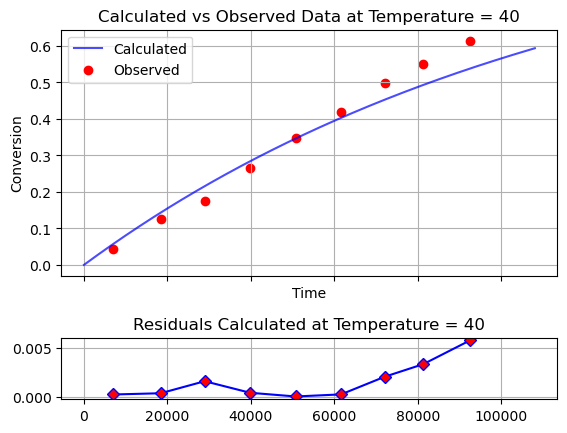

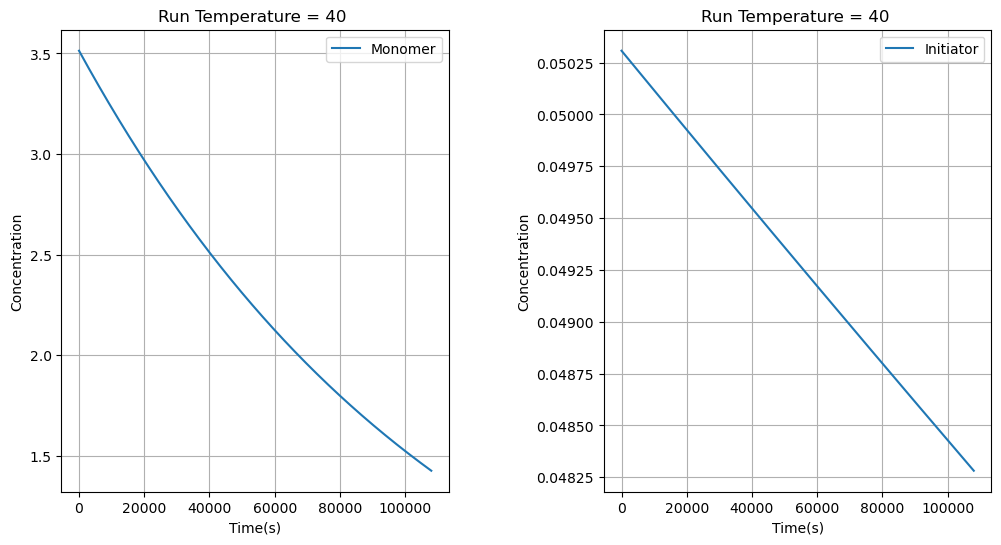



shapes are (107999,) (107999,)
Num. Avg. MW 165.007


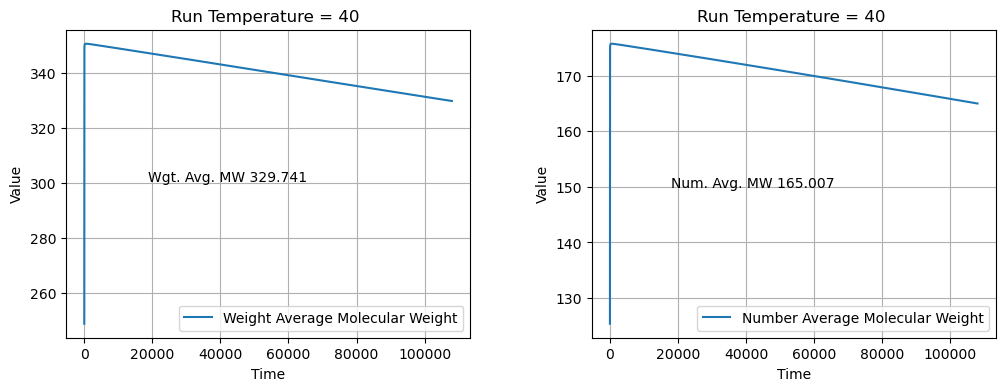

In [17]:
for T in Temperature_List:
    t0 = 0
    
    if (T == 70):
        tf = 12000 # [min] Final time
        x_obs = x_obs_70
        y_obs = y_obs_70
    if (T == 60):
        tf = 48000
        x_obs = x_obs_60
        y_obs = y_obs_60
    if (T == 50):
        tf = 48000   
        x_obs = x_obs_50
        y_obs = y_obs_50
    if (T == 40):
        tf = 108000 # [min] Final time
        x_obs = x_obs_40
        y_obs = y_obs_40
    rhoi, rhom, rhop, rhos, eta = Get_Densities(T)
   # density_list = Get_Densities(T)
   # format_and_print(density_list) 
   # Get_Volumes(T)
    V, Vi, Vm, Vs = Get_Volumes(T)
    M0 = Wm/Mwm/V
    S0 = Ws/Mws/V
    I0 = Wi/Mwi/V
    V0 = V
    X0 = 0   
    #starting_values = (V0, M0, S0, I0)
    #format_and_print (starting_values)
    ##### kd ###############
    A = 9.592e+15  #from Watpoly and paper
    Ea = 1.343e+5  #from Watpoly and paper  
    kd = Establish_kd(A, Ea, T)
    kp = Get_kp( T)
    #Calculate_Other_Rates(T)
    kt, ktc, ktd, ktrm, kts, ktcd = Calculate_Other_Rates(T)
    lambda0= 2e-9  #initialize living radicals 
    lambda1= 2e-9
    lambda2= 2e-9
    mu0=  2e-9     #initialize dead radicals
    mu1=  2e-9
    mu2 = 2e-9
    
    y0 = [I0, M0, lambda0, lambda1, lambda2, mu0, mu1, mu2,] 

    abserr = 1.e-10 
    relerr = 1.e-10

    #force evaluation at every second
    t_pts = np.linspace(t0, tf, tf)  # set number of points between t=t0 and t=tf. OPTIONAL
    #my preferred starting configuration
    sol =  solve_ivp(poly_AKS, (t0, tf), y0, t_eval=t_pts, rtol=relerr, atol=abserr, method='BDF', dense_output=True, args = [T, f] )  
    #sol =  solve_ivp(poly_AKS, (t0, tf), y0, t_eval=t_pts,   rtol=relerr, atol=abserr, method='BDF', dense_output=True )  
    my_residual, plot_array = Calculate_Residual(sol, x_obs, y_obs) 
    print (f'residual = {my_residual:.3f} at T = {T} and f= {f} with kp= {int(kp)}') #int assign is optional    
    x_calc = sol.t
    y_calc =  1 - (sol.y[1,:]/M0 )  #CONVERSION
    x_obs_integer = np.array(x_obs).astype(int) 
    #display calculated and experimental curves
    PlotResults (x_calc, y_calc, x_obs_integer, y_obs, plot_array , T, True)
    
    Plot_MandI (sol, T)
    print()
    print()
    Ww, Wn = Plot_Number_and_Weight_Averages(sol, T)


In [18]:
# T is set in cel 8
#residual = 0.014 at T = 40 and f= 0.58 with kp= 215
#residual = 0.021 at T = 50 and f= 0.58 with kp= 498
#residual = 0.003 at T = 60 and f= 0.58 with kp= 1096
#residual = 0.010 at T = 70 and f= 0.58 with kp= 2306
#residual = 0.014 at T = 40 and f= 0.58 with kp= 215 #on Desktop 1/9/24
#residual = 0.010 at T = 70 and f= 0.58 with kp= 2306
#residual = 0.014 at T = 40 and f= 0.58 with kp= 215
#

In [19]:
#print out values for comparison if needed
ki = 0.0  #this is soetimes used in a few models; first reaction of iitiator with monomer
k_array = [f, kd, kp, ki, ktc, ktd, ktrm, kt]
# a simple header
k_list  = (' f ', '   kd', '   kp',   '   ki', '   ktc', '   ktd', ' ktrm',   '  kt')
print(k_list)
format_and_print (k_array)

(' f ', '   kd', '   kp', '   ki', '   ktc', '   ktd', ' ktrm', '  kt')
5.80e-01 3.81e-07 2.15e+02 0.00e+00 5.90e-14 1.46e+07 1.07e+00 1.46e+07


In [20]:
#print out values for comparison if needed
#can be written to a file if needed
print(f'Initial value of Initiator: {I0:.3e}   final value of initiator: {sol.y[0][-1]: .3e}'  )
print(f'Initial value of Monomer:   {M0:.3e}   final value of Monomer: {sol.y[1][-1]: .3e}'  )
print(f'Final value of Conversion:  {1-(sol.y[1][-1])/M0:.3e}' )
print(f'Polydispersity = {Ww/Wn:.2e}' )
print(f'Final value of Wn is:  {Wn *1000*Mwm:.3e} after Mwm*1000' )
print(f'Final value of Ww is:  {Ww *1000*Mwm:.3e} after Mwm*1000' )



Initial value of Initiator: 5.031e-02   final value of initiator:  4.828e-02
Initial value of Monomer:   3.513e+00   final value of Monomer:  1.427e+00
Final value of Conversion:  5.939e-01
Polydispersity = 2.00e+00
Final value of Wn is:  1.652e+04 after Mwm*1000
Final value of Ww is:  3.302e+04 after Mwm*1000
